In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
import string
import warnings
from scipy.stats import pearsonr
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


In [4]:
# Download NLTK stopwords
nltk.download('stopwords')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anjali/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
df = pd.read_csv('/Users/anjali/Documents/MachineLearningProjects/RecommendationModel/tedx_dataset.csv')

In [8]:
# Inspect the dataset
print(df.head())
print("Dataset shape:", df.shape)
print("Missing values:", df.isnull().sum())

                                idx       main_speaker  \
0  8d2005ec35280deb6a438dc87b225f89     Alexandra Auer   
1  b3072cd11f40eb57fd259555264476c6  Elizabeth Gilbert   
2  4adc9fee977fa04c357ed4c9b52aa3cc       Butterscotch   
3  59c641a72b495d522a7932145d6c02b3         Ethan Lisi   
4  d227f2faf6ec185e54436d86463f499b      Daniel Finkel   

                                               title  \
0                    The intangible effects of walls   
1  It's OK to feel overwhelmed. Here's what to do...   
2                                  "Accept Who I Am"   
3               What it's really like to have autism   
4              Can you solve the sea monster riddle?   

                                             details           posted  \
0  More barriers exist now than at the end of Wor...  Posted Apr 2020   
1  If you're feeling anxious or fearful during th...  Posted Apr 2020   
2  Firing off her formidable beatboxing skills, m...  Posted Apr 2020   
3  "Autism is not a di

In [12]:
#Split the 'posted' column to extract year and month
splitted = df['posted'].str.split(' ', expand=True)
df['year'] = splitted[2].astype('int')
df['month'] = splitted[1]

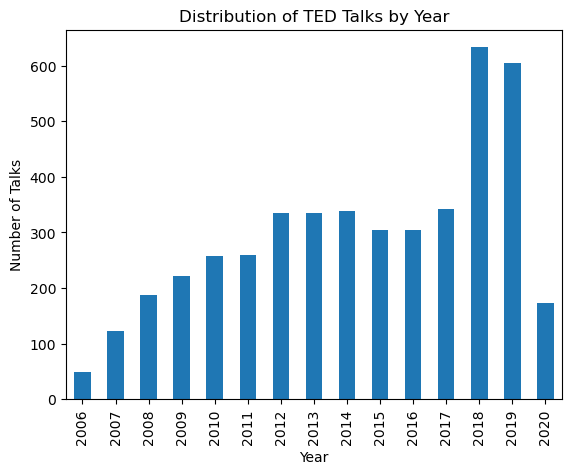

In [14]:
# Plot the distribution of TED talks by year
df['year'].value_counts().sort_index().plot.bar()
plt.title('Distribution of TED Talks by Year')
plt.xlabel('Year')
plt.ylabel('Number of Talks')
plt.show()

In [16]:
# Combine the title and details of the talk
df['details'] = df['title'] + ' ' + df['details']

In [18]:
# Keep relevant columns
df = df[['main_speaker', 'details']]

In [20]:
# Drop rows with missing details
df.dropna(inplace=True)

In [22]:
# Make a copy for future use
data = df.copy()

In [24]:
# Function to remove stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = [word.lower() for word in text.split() if word.lower() not in stop_words]
    return ' '.join(words)

In [26]:
# Apply the stopword removal
data['details'] = data['details'].apply(remove_stopwords)

In [28]:
# Function to clean punctuations
def cleaning_punctuations(text):
    signal = str.maketrans('', '', string.punctuation)
    return text.translate(signal)

In [32]:
# Apply punctuation cleaning
data['details'] = data['details'].apply(cleaning_punctuations)

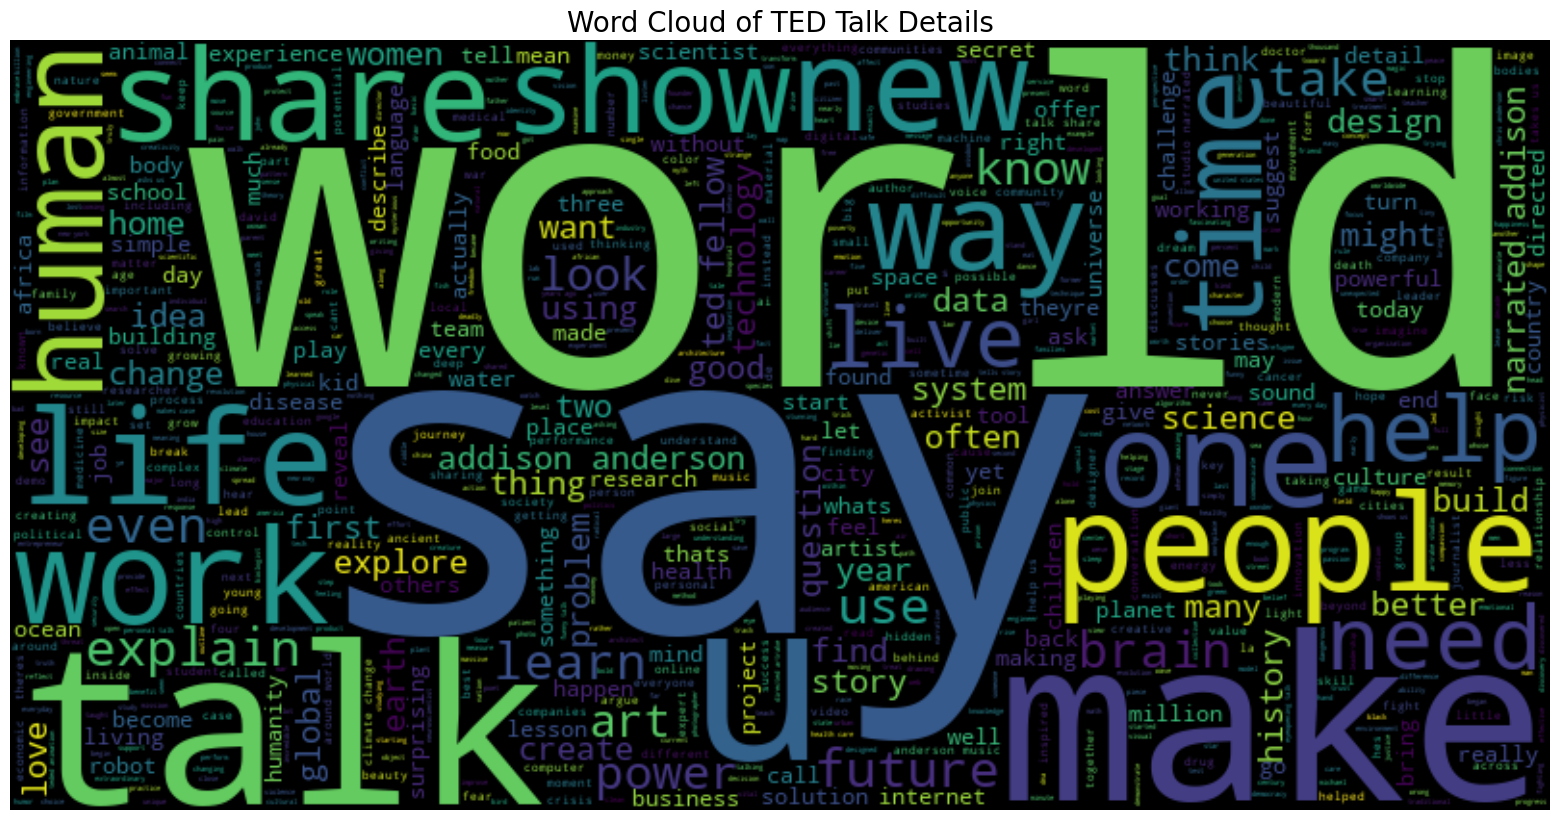

In [34]:
# Generate a word cloud
details_corpus = ' '.join(data['details'])
plt.figure(figsize=(20, 10))
wc = WordCloud(max_words=1000, width=800, height=400).generate(details_corpus)
plt.axis('off')
plt.imshow(wc, interpolation='bilinear')
plt.title('Word Cloud of TED Talk Details', fontsize=20)
plt.show()

In [36]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(analyzer='word')
vectorizer.fit(data['details'])

TfidfVectorizer()

In [38]:
# Function to calculate similarities
def get_similarities(talk_content, data=data):
    talk_array1 = vectorizer.transform(talk_content).toarray()

    sim = []
    pea = []
    for idx, row in data.iterrows():
        details = row['details']
        talk_array2 = vectorizer.transform([details]).toarray()

        # Calculate cosine similarity
        cos_sim = cosine_similarity(talk_array1, talk_array2)[0][0]

        # Calculate Pearson correlation
        pea_sim = pearsonr(talk_array1.squeeze(), talk_array2.squeeze())[0]

        sim.append(cos_sim)
        pea.append(pea_sim)

    return sim, pea

In [41]:
# Recommendation function
def recommend_talks(talk_content, data=data):
    talk_content_array = [talk_content]

    # Get similarities
    data['cos_sim'], data['pea_sim'] = get_similarities(talk_content_array, data)

    # Sort by similarity scores
    recommendations = data.sort_values(by=['cos_sim', 'pea_sim'], ascending=[False, False])

    # Display top 5 recommendations
    return recommendations[['main_speaker', 'details']].head()

# Example: Recommend TED talks
sample_talk = 'Time Management and working hard to become successful in life'
recommendations = recommend_talks(sample_talk)
print(recommendations)

          main_speaker                                            details
1758   Laura Vanderkam  gain control free time 168 hours week find tim...
2173     Philip Krinks  finding personal mission life philip krinks ha...
66           Fang Ruan  management lessons chinese business philosophy...
2075  Jessica Shortall  us needs paid family leave — sake future need ...
2446    Susan Etlinger  big data set data make feel comfortable succes...
